In [131]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from skimage import color, io
from scipy.misc import imresize

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils


np.random.seed(31337)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [ ]:
X_train=np.load('catfish-X_train.npy')
Y_train=np.load('catfish-Y_train.npy')
import gc
gc.collect()

Y_train = np_utils.to_categorical(Y_train, 2)

from keras.applications.resnet50 import preprocess_input, decode_predictions
preprocess_input(X_train)

In [149]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
preprocess_input(X_train)

array([[[[ -78.93900299,  -55.77899933,   27.31999969],
         [ -50.93900299,  -32.77899933,   49.31999969],
         [ -38.93900299,  -28.77899933,   51.31999969],
         ..., 
         [ -95.93900299,  -69.77899933,   51.31999969],
         [ -92.93900299,  -63.77899933,   56.31999969],
         [ -89.93900299,  -57.77899933,   63.31999969]],

        [[ -80.93900299,  -54.77899933,   27.31999969],
         [ -52.93900299,  -32.77899933,   50.31999969],
         [ -39.93900299,  -28.77899933,   51.31999969],
         ..., 
         [ -95.93900299,  -69.77899933,   51.31999969],
         [ -92.93900299,  -63.77899933,   56.31999969],
         [ -90.93900299,  -58.77899933,   62.31999969]],

        [[ -83.93900299,  -53.77899933,   33.31999969],
         [ -56.93900299,  -31.77899933,   53.31999969],
         [ -42.93900299,  -27.77899933,   54.31999969],
         ..., 
         [ -94.93900299,  -69.77899933,   51.31999969],
         [ -92.93900299,  -63.77899933,   56.31999969],

In [151]:
import sys
sys.path.append("keras-squeezenet")

from squeezenet import get_squeezenet

squeezenet_model = get_squeezenet(1000, dim_ordering='tf')
squeezenet_model.compile(loss="categorical_crossentropy", optimizer="adam")
squeezenet_model.load_weights('keras-squeezenet/model/squeezenet_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)

# from keras.layers import Input, Dense
# from keras.models import Model

# # Add final layer with 1 class
# layer = Dense(2, activation='softmax')(squeezenet_model.output)
# model = Model(input=squeezenet_model.inputs, output=layer)

# model.compile(loss='categorical_crossentropy', optimizer='adam')


# squeezenet_model.summary()

# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [170]:
l=squeezenet_model.layers
l=l[63]
print(l.input_shape)
squeezenet_model.summary()

(None, 13, 13, 512)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 113, 113, 64)  1792        input_6[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
_______________________________________________________________________

{'dim_ordering': 'tf', 'name': 'globalaveragepooling2d_6', 'trainable': True}

In [152]:
# Add final layer with 1 class
conv10= Convolution2D(2,1,1, activation='linear',name="conv10")
relu_conv10 = Activation(activation='relu', name='relu_conv10')
globalaveragepooling2d_3 = GlobalAveragePooling2D(name='globalaveragepooling2d_3')
loss =  Activation(activation='softmax', name='loss')

layer = conv10(squeezenet_model.layers[62].output)
layer = relu_conv10(layer)
layer = globalaveragepooling2d_3(layer)
layer = loss(layer)
model = Model(input=squeezenet_model.inputs, output=layer)

model.compile(loss='categorical_crossentropy', optimizer='adam')


model.summary()
globalaveragepooling2d_3.get_config()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 113, 113, 64)  1792        input_6[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

{'dim_ordering': 'tf', 'name': 'globalaveragepooling2d_3', 'trainable': True}

In [154]:
# Fit squeezenet the model 
history = model.fit(X_train, Y_train, 
                             #validation_data=(X_verify_squeezenet, Y_verify),
                             validation_split=0.33, 
                             nb_epoch=150, batch_size=300, 
                             callbacks=[early_stop],
                             verbose=0)
# list all data in history
print(history.history.keys())

Epoch 00019: early stopping
['loss', 'val_loss']


In [ ]:
score_test = model_squeezenet.evaluate(X_train_squeezenet, Y_train, verbose=0)

print("%s: %.2f%%" % (model_squeezenet.metrics_names[1], score_test[1]*100))

score_valid = model_squeezenet.evaluate(X_verify_squeezenet, Y_verify, verbose=0)

print("%s: %.2f%%" % (model_squeezenet.metrics_names[1], score_valid[1]*100))


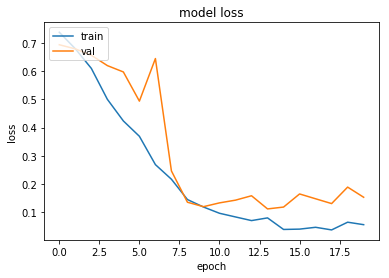

In [155]:
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [162]:
X_test_ResNet50=unpickle('ResNet50_test_preds.pickle')
X_test_squeezenet=unpickle('squeezenet_test_preds.pickle')

Y_test_squeezenet=model_squeezenet.predict(X_test_squeezenet)
Y_test_ResNet50=model_ResNet50.predict(X_test_squeezenet)

NameError: name 'unpickle' is not defined

In [163]:
plt.hist(Y_test_ResNet50, bins='auto', log=True) 
plt.title("Aspect ratio Histogram (log scale)")
plt.show()

plt.hist(Y_test_squeezenet, bins='auto', log=True) 
plt.title("Aspect ratio Histogram (log scale)")
plt.show()

NameError: name 'Y_test_ResNet50' is not defined

In [113]:
import re
test_ids=[re.split('/|\.',i)[1] for i in test_images]

In [118]:
Y_test_ResNet50_csv=np.column_stack((test_ids,Y_test_ResNet50))
Y_test_squeezenet_csv=np.column_stack((test_ids,Y_test_squeezenet))


In [120]:
np.savetxt('Y_test_ResNet50.csv',Y_test_ResNet50_csv, fmt="%s,%s", header=("id,label"),comments='')
np.savetxt('Y_test_squeezene.csv',Y_test_squeezenet_csv, fmt="%s,%s", header=("id,label"),comments='')

[ 0.  1.]


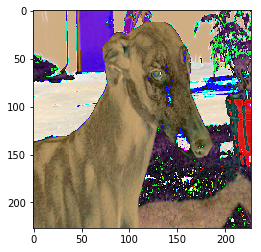

In [160]:
plt.imshow(X_train[2])
print(Y_train[2])